# Automatized datamining and weather forecast
    
    In this notebook we use datamining to get archived weather data from a website, then forecast the weather using linear regression.

In [1]:
#!pip install selenium

In [473]:
#selenium for data mining and web tasks
import selenium
from selenium import webdriver

from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
import time

import warnings
warnings.filterwarnings("ignore")

In [475]:
#There is a table on the page filled with temperature data.
#The function returns this in json format.
def get_data_from_table(days, month):
    json_lines=[]
    csv_lines=[]
    table= driver.find_element(By.TAG_NAME,'table')
    rws = table.find_elements(By.TAG_NAME,'tr')
    for row in rws:
        cols=row.find_elements(By.TAG_NAME,'td')
        if len(cols)>0:
            days += 1
            json_lines.append({
                'Day': str(days),
                'Month': str(month),
                'Min': cols[1].text,
                'Max': cols[2].text})
            csv_lines.append([days,month,cols[1].text,cols[2].text])
    return  json_lines, csv_lines  

In [476]:
#loops on all months in a year to get table data
#Limit:current year current month as exit point
Months=['Január','Február','Március','Április','Május','Június','Július','Augusztus','Szeptember','Október','November','December']
def getMonths(days,limit=12):
    json_data=[]
    csv_data=[]
    for i in range(len(Months)):
        if i < limit:
            selectMonth= Select(driver.find_element(By.ID,'ho'))
            searchButton= driver.find_element(By.ID,'button')
            selectMonth.select_by_visible_text(Months[i])
            searchButton.click()
            jsn,csv = get_data_from_table(days,i+1)
            json_data= json_data + jsn
            csv_data= csv_data + csv
            days=len(json_data)
            
    return json_data, csv_data

In [490]:
#loops on all years in an interval to get data
def get_data_from_web(start_year,end_year):
    json_data=[]
    csv_data=[]
    for year in range(start_year,end_year):
        days = 0
        selectYear=  Select(driver.find_element(By.ID,'ev'))
        selectYear.select_by_visible_text(str(year))
        if year==2021:
            json,csv = getMonths(days,limit=11)
            json_data = json_data + json
            csv_data = csv_data + csv
        else:
            json,csv = getMonths(days)
            json_data = json_data + json
            csv_data = csv_data + csv  
    return json_data, csv_data

In [491]:
# Invoke chrome browser
# DOWNLOAD chromedriver
driver = webdriver.Chrome(executable_path="C:\\chromedriver.exe")

# Maximize the browser window
driver.maximize_window()

# Url stores archived data of Budapest's weather
driver.get("http://idojarasbudapest.hu/archivalt-idojaras")

start_year = 2012
end_year = 2022

data_json, data_csv = get_data_from_web(start_year,end_year)
    
driver.close()

In [492]:
# Write data into json
import json 
with open('data.json', 'w') as outfile:
            json.dump(data_json, outfile)

import csv
# Write data into csv  
with open('data.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(data_csv)

In [493]:
#load data from json
with open('data.json') as infile:
            data=json.load(infile)
day_data=[]

for day in data:
    day_data.append([int(day['Day']),int(day['Month']),float(day['Min']),float(day['Max'])])

In [494]:
# data structure in json is now:
#[day_of_the_year, month, min_temperature_on_day, max_temperature_on_day]
#the data vector for training the network for predicting the avg temperature on day((min+max)/2):
#[day_of_the_year,last 7 days avg temperature values]
def preprocess_data(data):
    X=[]
    Y=[]
    for i in range(7,len(data)):
        X.append([data[i][0], (data[i-1][2]+data[i-1][3])/2,(data[i-2][2]+data[i-2][3])/2,(data[i-3][2]+data[i-3][3])/2,(data[i-4][2]+data[i-4][3])/2,(data[i-5][2]+data[i-5][3])/2,(data[i-6][2]+data[i-6][3])/2,(data[i-7][2]+data[i-7][3])/2])
        avg_temp = (data[i][2]+data[i][3])/2
        Y.append(avg_temp)
    return X,Y

In [495]:
#get X,Y
X,Y= preprocess_data(day_data)

#split data
nb_samples = len(Y)
test_split = 0.1

X_train = X[0:int(nb_samples*(1-valid_split-test_split))]
Y_train = Y[0:int(nb_samples*(1-valid_split-test_split))]
X_test  = X[int(nb_samples*(1-test_split)):]
Y_test  = Y[int(nb_samples*(1-test_split)):]

In [507]:
#training data is vector with length of 8
#[day_of_the_year,last 7 days avg temperature values]
print(len(X_train[0]))

2510


In [497]:
from sklearn import preprocessing
import numpy as np

#convert data to numpy array
X_train = np.array(X_train, dtype=np.float32)
X_test  = np.array(X_test, dtype=np.float32)


Y_train = np.array(Y_train, dtype=np.float32)
Y_test  = np.array(Y_test, dtype=np.float32)

#Standardization
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

In [521]:
from keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

#Model
model= Sequential()

#4 layer model with dense layers, linear regression
model.add(Dense(units=15,input_shape=(8,),activation='sigmoid'))
model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=64,activation='sigmoid')) 
model.add(Dense(units=1,activation='linear'))

# Using adam optimizer with small learning rate
model.compile(loss='mse',optimizer=Adam(learning_rate=0.0005))

In [522]:
# Training
history=model.fit(X_train,Y_train,epochs=100,verbose=2,batch_size=40, validation_split=0.2)

Epoch 1/100
51/51 - 1s - loss: 254.3617 - val_loss: 205.0439 - 788ms/epoch - 15ms/step
Epoch 2/100
51/51 - 0s - loss: 168.0880 - val_loss: 147.6796 - 357ms/epoch - 7ms/step
Epoch 3/100
51/51 - 0s - loss: 138.9097 - val_loss: 132.3293 - 191ms/epoch - 4ms/step
Epoch 4/100
51/51 - 0s - loss: 126.2368 - val_loss: 120.5999 - 112ms/epoch - 2ms/step
Epoch 5/100
51/51 - 0s - loss: 114.4479 - val_loss: 107.0919 - 132ms/epoch - 3ms/step
Epoch 6/100
51/51 - 0s - loss: 101.5348 - val_loss: 94.6255 - 123ms/epoch - 2ms/step
Epoch 7/100
51/51 - 0s - loss: 90.6755 - val_loss: 84.7380 - 128ms/epoch - 3ms/step
Epoch 8/100
51/51 - 0s - loss: 81.6700 - val_loss: 76.4363 - 125ms/epoch - 2ms/step
Epoch 9/100
51/51 - 0s - loss: 74.0604 - val_loss: 69.0177 - 129ms/epoch - 3ms/step
Epoch 10/100
51/51 - 0s - loss: 67.4242 - val_loss: 62.5054 - 133ms/epoch - 3ms/step
Epoch 11/100
51/51 - 0s - loss: 61.5409 - val_loss: 56.6081 - 302ms/epoch - 6ms/step
Epoch 12/100
51/51 - 0s - loss: 56.2098 - val_loss: 51.5025 - 

Epoch 99/100
51/51 - 0s - loss: 5.1669 - val_loss: 4.4129 - 128ms/epoch - 3ms/step
Epoch 100/100
51/51 - 0s - loss: 5.1183 - val_loss: 4.4118 - 120ms/epoch - 2ms/step


<AxesSubplot:>

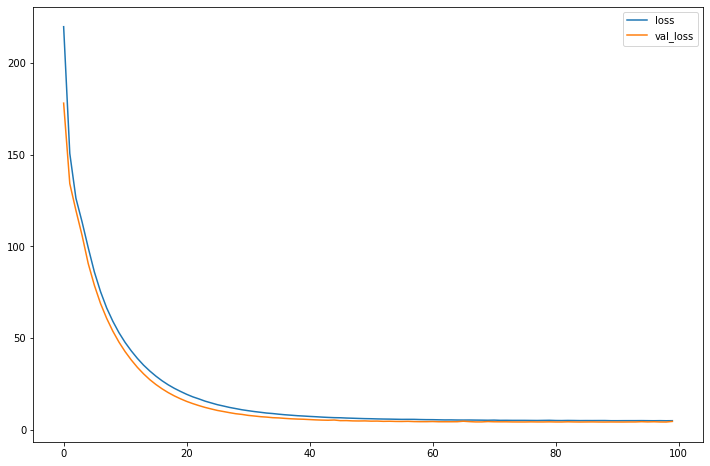

In [515]:
# Training loss visualization
import pandas as pd

loss_df = pd.DataFrame(model.history.history)
loss_df.plot(figsize=(12,8))

In [519]:
#preicit for test data
Y_pred = model.predict(X_test)

MAE: 1.8383571
MSE: 5.203668
RMSE: 2.281155


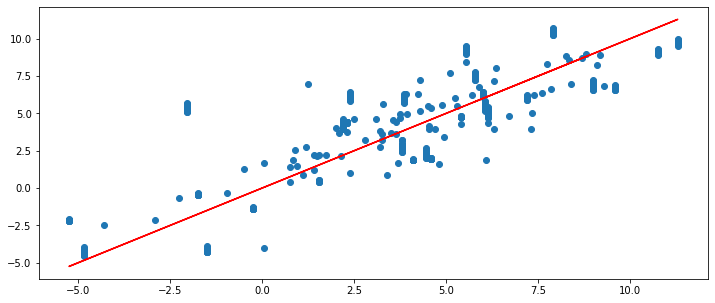

In [520]:
from sklearn import metrics
import matplotlib.pyplot as plt

# Errors
print('MAE:', metrics.mean_absolute_error(Y_test, Y_pred))  
print('MSE:', metrics.mean_squared_error(Y_test, Y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))

# Visualizing predictions
fig = plt.figure(figsize=(12,5))
plt.scatter(Y_test,Y_pred)

# The line shows perfect predictions
plt.plot(Y_test,Y_test,'r')
plt.show()

### Method:

In [523]:
# Method 1:

# Algorithm:
# Calculates the prediction for next day from the values
# Writes this value in the new vector, calculates next day

# This algorithm is unreliable for the long-term, the error grows rapidly, it would be better to train neural network on other data (indirectly to predict the temperature a month from now)

def calc_temp_on_day_from_now(day):
    future_X=[]
    future_Y=[]
    
    #the last data we have is from November 7th
    future_X.append(X[-1])
    
    # Make the new vector for November 8th by adding the temperature of Nov 7th
    future_X.append([future_X[0][0]+1,future_X[0][2],future_X[0][3],future_X[0][4],future_X[0][5],future_X[0][6],future_X[0][7],Y_test[-1]]) #nov 7
    
    # Scale the data, transform to numpy array
    future_X_sc= scaler.transform(future_X)
    future_X_sc= np.array(future_X_sc, dtype=np.float32)
    
    # Predict the temperature the day from now
    for i in range(day):
        # Predict the new temperature
        future_Y = model.predict(future_X_sc)
        # Update the vectors by adding the new one
        future_X.append([future_X[-1][0]+1,future_X[-1][2],future_X[-1][3],future_X[-1][4],future_X[-1][5],future_X[-1][6],future_X[-1][7],future_Y[-1]])
        
        #Convert data for prediction
        future_X_sc= scaler.transform(future_X)
        future_X_sc= np.array(future_X_sc, dtype=np.float32)
    return future_Y 
    

In [525]:
# The last data we have is from November 7th (311th day of the year)

# November 8 (312th day of the year) (1 days from our last data)
pred_Y=calc_temp_on_day_from_now(1)
pred_nov_8=pred_Y[-1]
print('Predicted temp for Nov. 8th:'+str(pred_nov_8))

# November 15 (319th day of the year) (8 days from our last data)
pred_Y=calc_temp_on_day_from_now(8)
pred_nov_15=pred_Y[-1]
print('Predicted temp for Nov. 15th:'+str(pred_nov_15))

# December 6 (340th day of the year) (29 days from our last data)
pred_Y=calc_temp_on_day_from_now(29)
pred_dec_6=pred_Y[-1]
print('Predicted temp for Dec. 6th:'+str(pred_dec_6))

Predicted temp for Nov. 8th:[10.226621]
Predicted temp for Nov. 15th:[9.246916]
Predicted temp for Dec. 6th:[6.9527884]
